# Overview
### This project implements an Object Detection and Distance Estimation system using the YOLO (You Only Look Once) algorithm. The primary objective is to detect and localize objects in images or video streams, estimate their distances from the camera, and provide real-time feedback. The system supports multiple object categories (e.g., "person", "car") and is designed to be scalable for other objects as well.


##   

# These our steps in this project

### 1. Setup the Environment
Install required libraries and dependencies.
Load the YOLO pre-trained weights and configuration files.

### 2. Import Libraries
Import necessary libraries such as cv2, numpy, matplotlib, gTTS, etc.

### 3. Load YOLO Model
Load the YOLO configuration file (yolov3.cfg) and the pre-trained weights (yolov3.weights).
Load the class names (coco.names).

### 4. Preprocess Input Data
Load the image or video frame.
Resize and normalize the input data for YOLO model compatibility.

### 5. Perform Object Detection
Pass the image or video frame through the YOLO network.
Detect the bounding boxes, class IDs, and confidence scores for each object.

### 6. Filter Object Detections
Apply Non-Maximum Suppression (NMS) to filter out redundant detections.
Display the bounding boxes and class labels for detected objects.

### 7. Distance Estimation
Calculate the estimated distance for each object detected, based on object size and camera parameters.
Use the known dimensions of objects to estimate distances (e.g., person, car).

### 8. Text-to-Speech Feedback
Use the gTTS library to convert the object and distance information into speech.
Output the speech to inform the user of the detected objects and their estimated distances.

### 9. User Interaction
Prompt the user to input the object to detect (e.g., "person", "car").
Suggest possible matches if the user’s input is incorrect.

### 10. Display Results
Display the detected objects with bounding boxes on the image or video stream.
Show the estimated distances of the detected objects.

##   

In [1]:
!pip install opencv-python pyttsx3

!wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names


--2024-11-28 18:04:30--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  23.3MB/s    in 14s     

2024-11-28 18:04:43 (17.4 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-11-28 18:04:44--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2

Saving photo-1501045661006-fcebe0257c3f.jpeg to photo-1501045661006-fcebe0257c3f (1).jpeg


Saving Transpo-AddisAbabastreet-464372138.webp to Transpo-AddisAbabastreet-464372138 (16).webp
Enter the object you want to detect: caar
YOLO does not recognize the object 'caar'. Did you mean one of these?
1. car
Selected object automatically: car


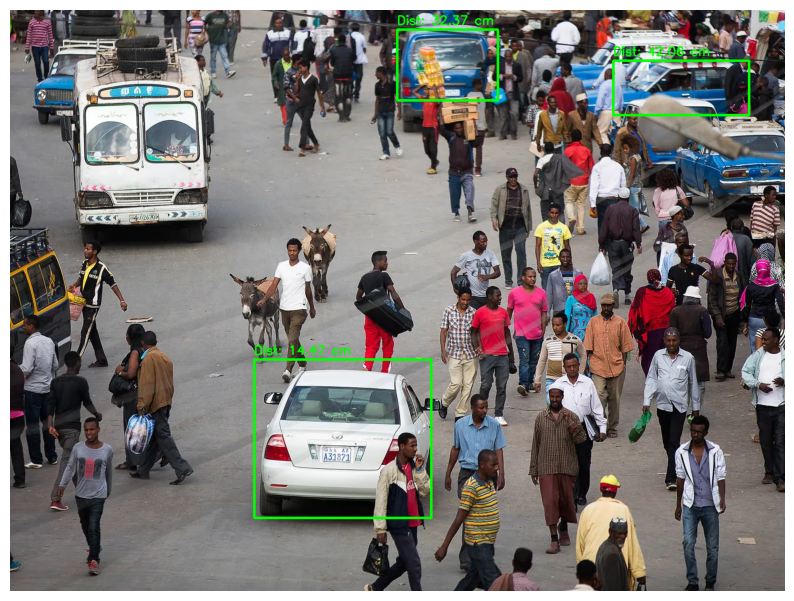

In [4]:
import cv2
import numpy as np
from gtts import gTTS
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from difflib import get_close_matches

# Read class names (objects YOLO can detect)
with open("coco.names", "r") as f:
    classes = [line.strip().lower() for line in f.readlines()]

# Load YOLO model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Upload image
from google.colab import files
uploaded = files.upload()

# Read the uploaded image
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)
height, width = image.shape[:2]

# Get the input object from the user
input_object = input("Enter the object you want to detect: ").strip().lower()

# Validate the input object
if input_object not in classes:
    # Search for close matches to the input object
    matches = get_close_matches(input_object, classes, n=3, cutoff=0.7)
    if matches:
        print(f"YOLO does not recognize the object '{input_object}'. Did you mean one of these?")
        for idx, match in enumerate(matches, 1):
            print(f"{idx}. {match}")

        # If there's only one match, select it automatically
        if len(matches) == 1:
            input_object = matches[0]
            print(f"Selected object automatically: {input_object}")
        else:
            # Let the user choose if there are multiple matches
            user_choice = input(f"Select the correct object number (1-{len(matches)}): ").strip()
            try:
                user_choice = int(user_choice) - 1
                if 0 <= user_choice < len(matches):
                    input_object = matches[user_choice]  # Update the input object
                    print(f"Selected object: {input_object}")
                else:
                    print("Invalid choice. Exiting.")
                    exit()
            except ValueError:
                print("Invalid input. Exiting.")
                exit()
    else:
        print(f"YOLO does not recognize the object '{input_object}' and no close matches were found.")
        exit()  # Exit if no matches are found

# Default focal length (can be adjusted based on camera type)
FOCAL_LENGTH = 1000  # Adjust this value as per your camera

# Process the image with YOLO
blob = cv2.dnn.blobFromImage(image, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Get the output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Perform object detection
outputs = net.forward(output_layers)

# Store object information
object_positions = []
boxes = []
confidences = []

# Define real object sizes (actual measurements)
real_sizes = {
    "person": 170,  # Actual height of a person in cm
    "car": 4.5,  # Actual length of a car in meters
    # More objects can be added here, e.g., "truck": 7.0, "bus": 12.0
}

# Analyze the detection results
for output in outputs:
    for detection in output:
        scores = detection[5:]  # Object class scores
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5 and classes[class_id] == input_object:  # Check for the input object
            # Extract coordinates
            center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype("int")
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))

# Apply Non-Maximum Suppression (NMS) to remove overlapping boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

# If objects are found, add their details
if len(indices) > 0:
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        # Calculate the distance to the camera based on the real size of the object
        if input_object in real_sizes:
            real_size = real_sizes[input_object]  # Get the real size of the object
            # If the object is a person, use height; for car, use length
            distance_to_camera = (real_size * FOCAL_LENGTH) / h
        else:
            distance_to_camera = 0  # If real size is unknown

        # Determine the relative location of the object
        if x < width // 3:
            location = "left"
        elif x > 2 * width // 3:
            location = "right"
        else:
            location = "center"

        object_positions.append({
            "location": location,
            "distance": distance_to_camera,
            "coordinates": (x, y, w, h)
        })

# Prepare the text for speech output
if object_positions:
    text = f"There are {len(object_positions)} {input_object}s in the image. "
    for i, obj in enumerate(object_positions):
        if obj["distance"] > 0:
            text += f"{input_object.capitalize()} {i+1} is located {obj['location']} at a distance of {obj['distance']:.2f} cm. "
        else:
            text += f"{input_object.capitalize()} {i+1} is located {obj['location']}. "
else:
    text = f"No {input_object}s found in the image."

# Generate the audio file using text-to-speech
tts = gTTS(text, lang='en')
tts.save("object_info.mp3")

# Play the generated audio file
display(Audio("object_info.mp3", autoplay=True))

# Draw bounding boxes around detected objects
for obj in object_positions:
    x, y, w, h = obj["coordinates"]
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), thickness=3)
    cv2.putText(image, f"Dist: {obj['distance']:.2f} cm", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Display the image with detected objects
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()
